In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import os
import glob
import cv2
import functools
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.keras import layers, losses, models

In [2]:
INPUT_PATH = 'G:/data/Carvana Image Masking Challenge/carvana-image-masking-challenge/'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")
TEST_DATA = os.path.join(DATA_PATH, "test")
TRAIN_MASKS_CSV_FILEPATH = os.path.join(DATA_PATH, "train_masks.csv")
METADATA_CSV_FILEPATH = os.path.join(DATA_PATH, "metadata.csv")

TRAIN_MASKS_CSV = pd.read_csv(TRAIN_MASKS_CSV_FILEPATH)
METADATA_CSV = pd.read_csv(METADATA_CSV_FILEPATH)

In [3]:
img_dir = os.path.join(DATA_PATH, "train")
label_dir = os.path.join(DATA_PATH, "train_masks")

df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [4]:
# Split data in train and test set
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


In [5]:
def get_image_matrix(image_path):    
    img = Image.open(image_path)
    return np.asarray(img, dtype=np.uint8)

Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


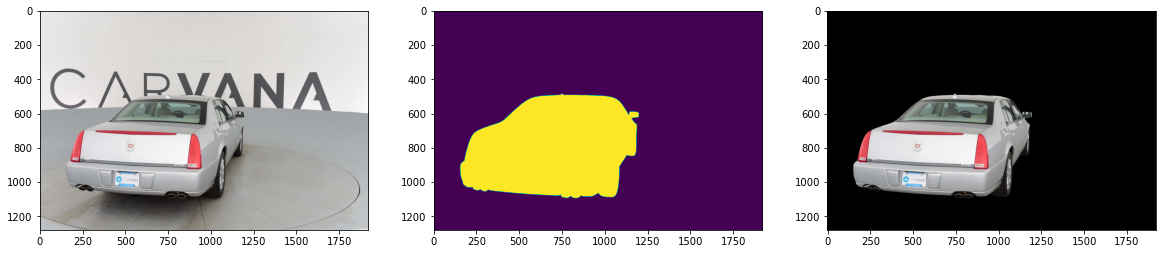

In [6]:
image_id = 118

plt.figure(figsize=(20, 20))
img = get_image_matrix(x_train_filenames[image_id])
mask = get_image_matrix(y_train_filenames[image_id])
img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}"
      .format(img.shape, img.dtype, mask.shape, mask.dtype) )

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(img_masked);

In [7]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 5

In [8]:
def _process_pathnames(fname, label_path):
    # Мы отображаем эту функцию для каждой пары путей
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_jpeg(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    # gif изображения возвращаются как (num_frames, h, w, c)
    label_img = tf.image.decode_gif(label_img_str)[0]
    # Изображение метки должно иметь значения только 1 или 0, что указывает на пиксель
    # объекта (автомобиля) или нет (фона). Мы берем только первый канал.
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    return img, label_img

In [9]:
a, b = _process_pathnames(x_train_filenames[0], y_train_filenames[0])

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """Этот fn будет выполнять горизонтальное или вертикальное смещение"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([], 
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])

        output_img = tfa.image.transform(output_img,
                                             [width_shift_range, height_shift_range])
        label_img = tfa.image.transform(label_img,
                                             [width_shift_range, height_shift_range])
    return output_img, label_img

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                    lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                    lambda: (tr_img, label_img))
    return tr_img, label_img

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Измените размер изображения до некоторого размера, например [512, 512]
             scale=1,  # Масштабное изображение, например 1/255.
             hue_delta=0,  # Регулирование оттенка изображения RGB по случайному коэффициенту
             horizontal_flip=False,  # Рандом левого или правого flip,
             width_shift_range=0,  # Случайно сдвиг изображения по горизонтали
             height_shift_range=0):  # Случайно сдвинуть изображение по вертикали
    if resize is not None:
        # Изменить размер изображений (gif b jpg)
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, tf.float32) * scale
    img = tf.cast(img, tf.float32) * scale 
    return img, label_img

In [13]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
    num_x = len(filenames)
    # Создать набор данных из пути файлов и лейбов
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    #Сопоставьте нашу функцию предварительной обработки с каждым элементом в нашем наборе данных, 
    #используя преимущества многопоточности
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    if shuffle:
        dataset = dataset.shuffle(num_x)


    # It's necessary to repeat our data for all epochs 
    dataset = dataset.repeat().batch(batch_size)
    return dataset

In [14]:
dat = tf.data.Dataset.from_tensor_slices((x_train_filenames, y_train_filenames))

In [15]:
dat

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [16]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [17]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

In [18]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [19]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

In [20]:
# Давайте посмотрим на некоторые из дополненных изображений
data_aug_iter = tf.compat.v1.data.make_one_shot_iterator(temp_ds)

next_element = data_aug_iter.get_next()

with tf.compat.v1.Session() as sess: 
    batch_of_imgs, label = sess.run(next_element)

    # Запуск следующего элемента приведет к созданию пакета изображений
    plt.figure(figsize=(10, 10))
    img = batch_of_imgs[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(label[0, :, :, 0])
    plt.show()

In [21]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

In [22]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [23]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [24]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [25]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [26]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [27]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [28]:
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', mode='max', save_best_only=True)

In [29]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Train for 1357 steps, validate for 340 steps
Epoch 1/5
   1/1357 [..............................] - ETA: 1:10:30WARNING:tensorflow:Can save best model only with val_dice_loss available, skipping.


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Input transform should be num_images x 8 or 1 x 8
	 [[{{node PartitionedCall_1/transform/Addons>ImageProjectiveTransformV2}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) Invalid argument:  Input transform should be num_images x 8 or 1 x 8
	 [[{{node PartitionedCall_1/transform/Addons>ImageProjectiveTransformV2}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_9707]

Function call stack:
distributed_function -> distributed_function
